# 📈 Basic Portfolio Optimisation

## 1. Get The Data
- Using `yfinance` API and the close proces for the tickers

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from typing import Final

In [47]:
END_DATE = datetime.today()
DAYS_IN_A_YEAR = 365
NUMBER_OF_YEARS = 5
START_DATE = END_DATE - timedelta(days = NUMBER_OF_YEARS * DAYS_IN_A_YEAR)

TICKERS: Final[list[str]] = ['AAPL', 'MSFT', 'SPY', 'GLD']

data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)['Close']
print(type(data))
data.head()

<class 'pandas.core.frame.DataFrame'>


Ticker,AAPL,GLD,MSFT,SPY
Date,,,,
2020-10-26,111.911201,178.550003,201.430008,316.399994
2020-10-27,113.418892,179.020004,204.469513,315.309235
2020-10-28,108.166206,176.130005,194.334732,304.532349
2020-10-29,112.173820,175.399994,196.290726,307.627411
2020-10-30,105.890060,176.199997,194.133392,304.420441


## 2. Analyse the Data
- Obtain the log returns and visualise the distibution in histograms
- Assess the Covariance for the financial instruments

In [3]:
import numpy as np

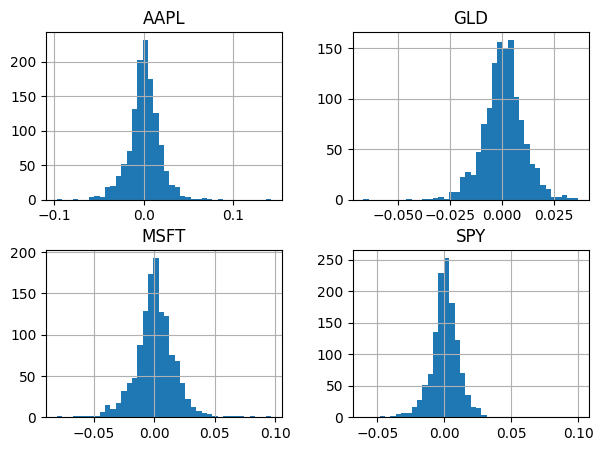

In [4]:
returns = np.log(data / data.shift(1))
returns.hist(bins=40, figsize=(7, 5));

In [5]:
# Annualised mean returns
returns.mean() * 252

Ticker
AAPL    0.169247
GLD     0.151533
MSFT    0.191476
SPY     0.151449
dtype: float64

In [6]:
# Annualised covariance matrix
returns.cov() * 252

Ticker,AAPL,GLD,MSFT,SPY
Ticker,,,,
AAPL,0.080590,0.003696,0.047208,0.036941
GLD,0.003696,0.024263,0.003346,0.003254
MSFT,0.047208,0.003346,0.066866,0.033864
SPY,0.036941,0.003254,0.033864,0.029603


## 3. Basic Theory

- It's assumed that the investor is not allowed to have short positions in a financial instrument (onloy long positions allowed)
- 100% of investors wealth has to be divided up among the availabole financial instruments

In [7]:
# Create 4 (number of tickers) random weights that sum to 1.0 
weights = np.random.random(len(TICKERS))
weights /= np.sum(weights)
weights

array([0.11283612, 0.24747392, 0.39222666, 0.2474633 ])

In [8]:
weights.sum()

np.float64(1.0)

In [9]:
# The expected portfolio returns taking the historical mean perfromance of each instrument and random weights
np.sum(returns.mean() * weights) * 252

np.float64(0.16917757495133526)

In [10]:
# Annualised portfolio variance given the portfolio weights
var = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
var

np.float64(0.028681555635596215)

In [11]:
# Annualised portfolio volatility given the portfolio weights
import math
np.sqrt(var)

np.float64(0.16935629789174128)

## 4. Monte Carlo Simulation of Expected Returns and Volatility

In [12]:
from numpy.typing import NDArray

def get_portfolio_returns(weights: NDArray[np.float64]) -> np.float64:
    return np.sum(returns.mean() * weights) * 252

def get_portfolio_volatility(weights: NDArray[np.float64]) -> np.float64:
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def create_random_weights(num_weights: int) -> NDArray[np.float64]:
    weights = np.random.random(num_weights)
    weights /= np.sum(weights)
    return weights

portfolio_rets = []
portfolio_vols = []

I = 2500 # number of simulations
for p in range(I):
    weights = create_random_weights(len(TICKERS))
    portfolio_rets.append(get_portfolio_returns(weights))
    portfolio_vols.append(get_portfolio_volatility(weights))

portfolio_rets = np.array(portfolio_rets)
portfolio_vols = np.array(portfolio_vols)

In [13]:
from pylab import mpl, plt

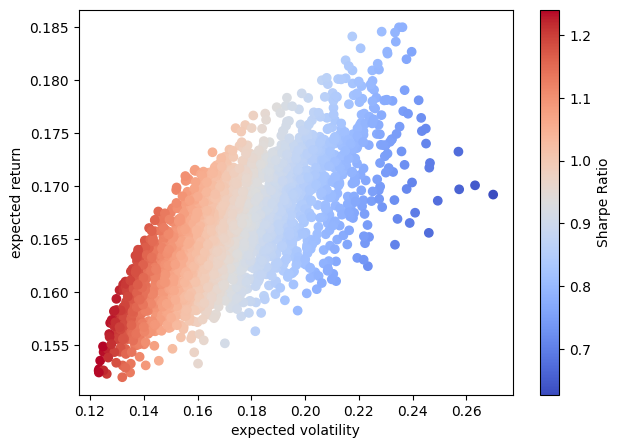

In [14]:
plt.figure(figsize=(7, 5))
plt.scatter(
    portfolio_vols,
    portfolio_rets,
    c=portfolio_rets/portfolio_vols,
    marker='o',
    cmap='coolwarm'
)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe Ratio');

## 5. Optimal Portfolio
- Using a minimisation function to find the optimal portfolio weights given constraints
- Maximisation of sharpe ratio is used to derive the maximum value and the optimal portfolio composition.

In [15]:
import scipy.optimize as sco

In [16]:
def min_func_sharpe(weights: NDArray[np.float64]) -> np.float64:
    '''
    Function to be minimised.
    
    Formally the negative value of the sharpe ratio is minimised to derive the maximum
    value and the optimal portfolio composition
    '''
    return -get_portfolio_returns(weights) / get_portfolio_volatility(weights)

# Constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(TICKERS)))
equal_weights = np.array(len(TICKERS) * [1. / len(TICKERS)])
equal_weights

array([0.25, 0.25, 0.25, 0.25])

In [17]:
min_func_sharpe(equal_weights)

np.float64(-0.9807778570191134)

### Maximum Sharpe Ratio Portfolio (MSRP)
- Maximise risk-adjusted return, measured by the Sharpe ratio
- Balances expected return and risk to get the best return per unit of volatility.
- Depends on both expected returns and covariance matrix
- Lies tangentially to the efficient frontier from the risk-free rate (called the tangency portfolio).


In [18]:
opts = sco.minimize(min_func_sharpe, equal_weights, method='SLSQP', bounds=bnds, constraints=cons)
opts

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -1.2452387772177083
           x: [ 0.000e+00  5.626e-01  7.214e-02  3.652e-01]
         nit: 6
         jac: [ 1.722e-01 -4.625e-04  8.130e-04  5.521e-04]
        nfev: 30
        njev: 6
 multipliers: [-3.529e-07]

In [19]:
# Optimal portfolio weights
opts['x'].round(3)

array([0.   , 0.563, 0.072, 0.365])

In [20]:
# Optimal portfolio return
get_portfolio_returns(opts['x']).round(3)

np.float64(0.154)

In [21]:
# Optimal portfolio volatility
get_portfolio_volatility(opts['x']).round(3)

np.float64(0.124)

In [22]:
# Share Ratio
get_portfolio_returns(opts['x']) / get_portfolio_volatility(opts['x'])

np.float64(1.2452387772177083)

### Minimum Volatility Portfolio (MVP)
- Minimise the portfolio’s total risk (volatility), regardless of expected return.
- Focuses purely on risk minimisation.
- The MVP is the point on the efficient frontier with the lowest variance.
- It does not consider expected returns — only covariances (the structure of risk).
- Often dominated by low-volatility assets (like bonds or defensives)

In [23]:
# get the minimum variance portfolio 
optv = sco.minimize(get_portfolio_volatility, equal_weights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.12224206563675957
           x: [ 0.000e+00  5.564e-01  2.653e-18  4.436e-01]
         nit: 8
         jac: [ 1.513e-01  1.219e-01  1.385e-01  1.226e-01]
        nfev: 41
        njev: 8
 multipliers: [ 1.222e-01]

In [24]:
# Optimal portfolio weights
optv['x'].round(3)

array([0.   , 0.556, 0.   , 0.444])

In [25]:
# Optimal portfolio return
get_portfolio_returns(optv['x']).round(3)

np.float64(0.151)

In [26]:
# Optimal portfolio volatility
get_portfolio_volatility(optv['x']).round(3)

np.float64(0.122)

In [27]:
# Share Ratio
get_portfolio_returns(optv['x']) / get_portfolio_volatility(optv['x'])

np.float64(1.2393095097626219)

### Efficient Frontier
- represents the set of optimal portfolios that offer the highest expected return for a given level of risk, or equivalently, the lowest risk for a given level of expected return

In [31]:
# constraints
cons = (
    {'type': 'eq', 'fun': lambda x: get_portfolio_returns(x) - tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
)

# bounds
bnds = tuple((0, 1) for x in weights)

# target returns
trets = np.linspace(0.05, 0.2, 50)
tvols = []

for tret in trets:
    res = sco.minimize(get_portfolio_volatility, equal_weights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])

tvols = np.array(tvols)

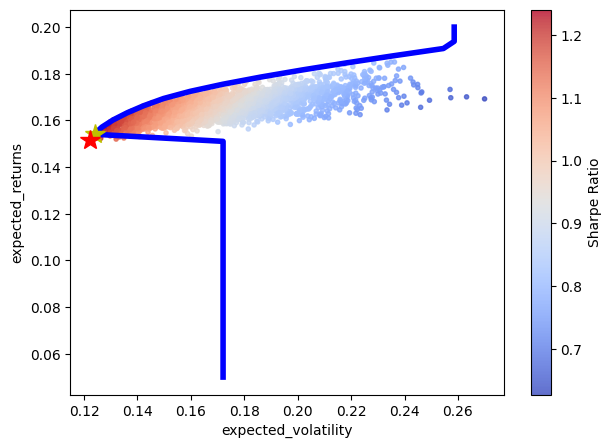

In [33]:
plt.figure(figsize=(7, 5))
plt.scatter(
    portfolio_vols,
    portfolio_rets,
    c=portfolio_rets / portfolio_vols,
    marker='.',
    alpha=0.8,
    cmap='coolwarm'
)
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(get_portfolio_volatility(opts['x']), get_portfolio_returns(opts['x']), 'y*', markersize=15.0)
plt.plot(get_portfolio_volatility(optv['x']), get_portfolio_returns(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected_volatility')
plt.ylabel('expected_returns')
plt.colorbar(label='Sharpe Ratio');

## 6. Capital Market Line
- Shows the risk–return trade-off for efficient portfolios that include a risk-free asset.
- Every point on the CML corresponds to a portfolio that is optimally diversified between the risk-free asset and the market portfolio.

In [34]:
import scipy.interpolate as sci

In [36]:
# Index position of minimum volatility position
ind = np.argmin(tvols)

# Relevant portfolio volatility and return values
evols = tvols[ind:]
erets = trets[ind:]

# Ensure evols is strictly increasing
sort_idx = np.argsort(evols)
evols = evols[sort_idx]
erets = erets[sort_idx]

# Cubic spline interpolation
tck = sci.splrep(evols, erets)

In [37]:
def f(x: NDArray[np.float64]) -> NDArray[np.float64]:
    '''Efficient frontier function (splines interpolation). '''
    return sci.splev(x, tck, der=0)

def df(x: NDArray[np.float64]) -> NDArray[np.float64]:
    '''First derivative of efficient frontier function.'''
    return sci.splev(x, tck, der=1)

In [38]:
def equations(p: list, rf: float = 0.01) -> tuple[float]:
    eq1 = rf - p[0]
    eq2 = rf  + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

# Optimal parameter values
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([ 1.00000000e-02, -6.78771563e+04,  1.46966102e-01])

In [39]:
np.round(equations(opt), 6)

array([ 0.      ,  0.000209, -0.001162])

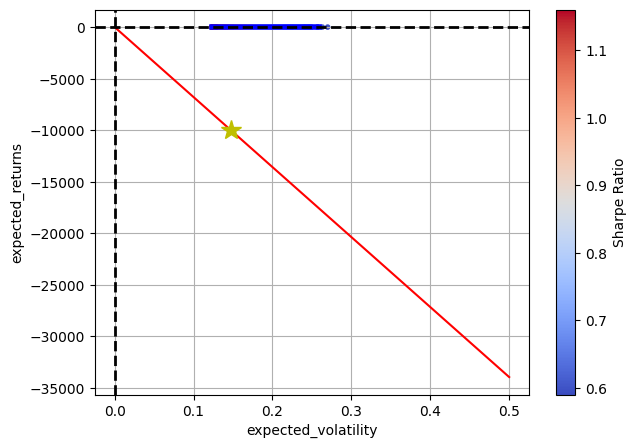

In [42]:
plt.figure(figsize=(7, 5))
plt.scatter(
    portfolio_vols,
    portfolio_rets,
    c=(portfolio_rets - 0.01) / portfolio_vols, 
    marker='.',
    cmap='coolwarm'
)
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.5)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected_volatility')
plt.ylabel('expected_returns')
plt.colorbar(label='Sharpe Ratio');